<a href="https://colab.research.google.com/github/Nusuit/Statistical_Analysis/blob/huykien/Rating_Based_On_Feedback_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**<h1>IMPORTING LIBRARIES<h1>**

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**<h1>HYPERPARAMETRERS AND DIRECTORIES<h1>**

In [ ]:
input_path = "/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/olist_order_reviews_dataset.csv"


# HYPERPARAMETERS
RANDOM_STATE = 12
TRAIN_SPLIT = 0.80
OOV_TOK = "<OOV>"  # Out-of-vocabulary token
VOCAB_SIZE = 10000  # Process the 10,000 most common words
EMBEDDING_DIM = 16  # 16-dimensional word vectors. Example: "happy" → [0.1, -0.3, 0.8, 0.5, -0.4, 0.2, 0.0, -0.1, 0.7, -0.5, 0.3, 0.4, -0.2, 0.6, -0.9, 0.1]
MAX_LENGTH = 120  # Can handle text lengths of up to 120 words
BATCH_SIZE = 128  # For example, with 10,000 samples, it will divide into 78 batches and take 128 samples per batch
EPOCHS = 25  # Train the model repeatedly for 25 iterations
EARLY_STOPPING_CRITERIA = 3  # Stop if no improvement after 3 epochs
DROPOUT_P = 0.4
LEARNING_RATE = 0.01  # Learning rate of the model
MOMENTUM = 0.9  # Use 90% of the previous path, and if there's a new path, incline towards the previous one
MAX_ITER = 10000
N_JOBS = 8  # Use 8GB of RAM

**<h1>DATA LOADING AND PRE-PROCESSING**

In [ ]:
data = pd.read_csv(input_path)
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [ ]:
def clean_data(data, column_text='review_comment_message',
               column_score='review_score',
               points_cut=[0, 2, 5],  # Split into (0-2), (2-5)
               classes=[0, 1]):  # 1 if satisfied, 0 otherwise

    df_bin = data
    df_bin = df_bin.dropna(subset=[column_text])
    df_bin['label'] = pd.cut(df_bin[column_score], bins=points_cut, labels=classes)  # Filter the column_score column using points_cut and classes
    df_bin = df_bin.rename(columns={column_text: 'text'})
    df_bin = df_bin[['text', 'label']]

    df_cat = data
    df_cat = df_cat.dropna(subset=[column_text])
    df_cat = df_cat.rename(columns={column_text: 'text', column_score: 'label'})
    df_cat = df_cat[['text', 'label']]
    return df_bin, df_cat


data_bin, data_cat = clean_data(data)


**<h1>Data Distribution among classes**

In [ ]:
fig = px.bar(x = np.unique(data_cat["label"]),
             y = [list(data_cat["label"]).count(i) for i in np.unique(data_cat["label"])] ,
             color = np.unique(data_cat["label"]) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Ratings")
fig.update_yaxes(title = "Number of Reviews")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Rating vs No of reviews ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
fig = px.bar(x = np.unique(data_bin["label"]),
             y = [list(data_bin["label"]).count(i) for i in np.unique(data_bin["label"])] ,
             color=np.unique(data_bin["label"]) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Ratings")
fig.update_yaxes(title = "Number of Reviews")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Rating vs No of reviews ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

**<h3>WORDCLOUD**

In [ ]:
import nltk
nltk.download('stopwords')  # Stopwords are commonly used words like "and," "of," "but," which don't carry much meaning

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

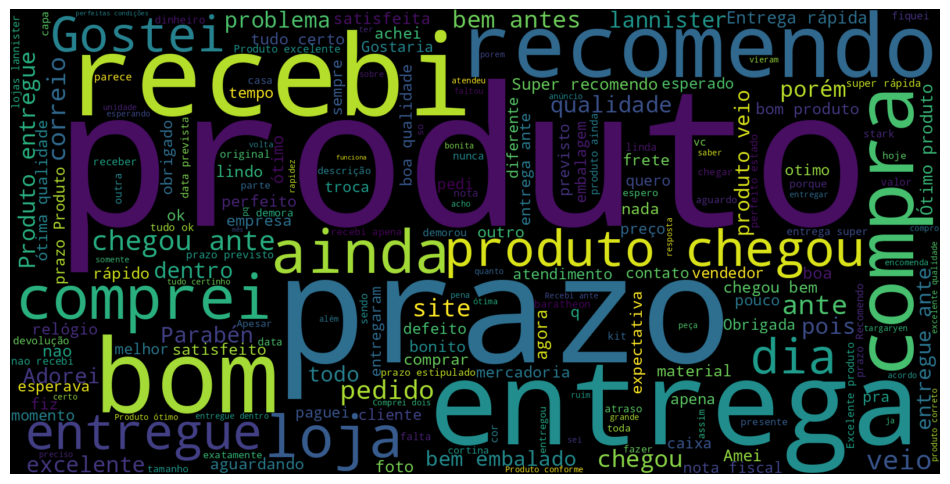

In [ ]:
stop_words = stopwords.words('portuguese')  # Remove stopwords in Portuguese, as this is Brazil's primary language
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
                      width=1600, height=800).generate(' '.join(data_bin["text"]))
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

In [ ]:
def split_test_train(data, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
    df_train = data.sample(frac = split_train, random_state = random_state)
    df_test = data.drop(df_train.index)

    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for index, train in df_train.iterrows():
        X_train.append(str(train['text']))
        y_train.append(train['label'])

    for index, test in df_test.iterrows():
        X_test.append(str(test['text']))
        y_test.append(test['label'])

    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train , y_train , X_test , y_test


X_train , y_train , X_test , y_test = split_test_train(data_bin, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE)

In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(X_train)

def preprocess(X_train, X_test, max_length, vocab_size, trunc_type='post', oov_tok="<OOV>"):

    training_sequences = tokenizer.texts_to_sequences(X_train)  # Tokenize into integers, e.g., "sản phẩm" = 1, "tốt" = 2 => "sản phẩm tốt" = [1, 2]
    X_train_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)  # Handle token length: truncate the end if too long or pad with 0s if too short

    testing_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(testing_sequences, maxlen=max_length)

    return X_train_padded, X_test_padded

X_train, X_test = preprocess(X_train, X_test, MAX_LENGTH, VOCAB_SIZE)


**<h1>LSTM MODEL**

In [ ]:
def create_model():

    input = tf.keras.Input(shape=(MAX_LENGTH,))

    # Embedding words into vectors
    x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH)(input)

    # LSTM layer to summarize and link vectors
    # It combines the vector of the first word with the second to form a third vector that generalizes both
    x = tf.keras.layers.LSTM(32, return_sequences=True)(x)

    # LSTM layer for final summarization
    # After creating a final summarized vector, it outputs the last vector without linking further
    x = tf.keras.layers.LSTM(32)(x)

    # Dropout to remove neurons, reducing dependency on specific features
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)

    # Dense layer to learn complex features from the context summarized by LSTM
    x = tf.keras.layers.Dense(800, activation='relu')(x)

    # Dropout to prevent over-reliance on certain features and improve generalization
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)

    # Dense layer for refining and simplifying features
    # Uses 800 neurons initially, then reduces to 400 to focus on key features
    # ReLU sets negative values in the output vector to 0
    x = tf.keras.layers.Dense(400, activation='relu')(x)

    # Dropout again to reduce dependencies and improve feature generalization
    x = tf.keras.layers.Dropout(DROPOUT_P)(x)

    # Final Dense layer to output a single value
    # Uses sigmoid activation to calculate a probability between 0 and 1 (e.g., ~80%)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Compile the model to ensure the process follows the intended sequence
    model = tf.keras.Model(input, output)

    return model


In [ ]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Stops training if the loss value does not improve. For example, if the true label is 1 and the predicted probability is 0.9, the loss = 0.105 based on the formula.
    patience=EARLY_STOPPING_CRITERIA,  # If val_loss (validation loss) does not improve for 3 consecutive epochs (set above), training will stop
    verbose=1,
    restore_best_weights=True  # After early stopping, Keras restores the model weights to those from the epoch with the best validation performance
)

model = create_model()

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),  # Binary Cross-Entropy compares the model's predictions with the actual labels, calculates the difference, and outputs the model's error level
    optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),  # Optimizer based on parameters defined at the start of the project
    metrics=['accuracy']  # Requests Keras to display accuracy on the training and validation sets during training
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 120, 32)             │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 800)                 │          26,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 400)                 │         320,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             401 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 521,793 (1.99 MB)

 Trainable params: 521,793 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

**<h3>Training LSTM Model**

In [ ]:
history = model.fit(x = X_train,
                    y = y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks= [earlyStoppingCallback]
)
history = pd.DataFrame(history.history)

Epoch 1/25
257/257 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7346 - loss: 0.5985 - val_accuracy: 0.7307 - val_loss: 0.5250
Epoch 2/25
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7444 - loss: 0.5171 - val_accuracy: 0.7751 - val_loss: 0.4854
Epoch 3/25
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7793 - loss: 0.4612 - val_accuracy: 0.8399 - val_loss: 0.3633
Epoch 4/25
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8376 - loss: 0.3599 - val_accuracy: 0.8572 - val_loss: 0.3214
Epoch 5/25
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8533 - loss: 0.3276 - val_accuracy: 0.8514 - val_loss: 0.3515
Epoch 6/25
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8676 - loss: 0.3069 - val_accuracy: 0.8714 - val_loss: 0.2923
Epoch 7/25
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8743 - loss: 0.2941 - val_accuracy: 0.8781 - val_loss: 0.2791
Epoch 8/25
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8822 - loss: 0.2775 - val_acc

**<h3>Visualizing Training Results**

In [ ]:
x = px.line(data_frame=history, y=["accuracy", "val_accuracy"],
            markers=True)  # Add markers to the points
x.update_xaxes(title="Number of Epochs",
               rangeslider_visible=True)  # Enable the range slider
x.update_yaxes(title="Accuracy")
x.update_layout(showlegend=True,
    title={
        'text': 'Accuracy vs Number of Epochs',
        'y': 0.94,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [ ]:
x = px.line(data_frame= history ,
            y= ["loss" , "val_loss"] ,
            markers = True )
x.update_xaxes(title="Number of Epochs",
              rangeslider_visible = True)
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

**<h3>Evaluating LSTM model**

In [ ]:
# Use the trained model to predict probabilities for each sample in the test set (X_test)
# Setting verbose=0 suppresses any output during the prediction process for a silent execution
y_preds_prob = model.predict(X_test, verbose=0)

# If the predicted probability is greater than 0.5, assign a label of 1; otherwise, assign 0
y_preds = np.where(y_preds_prob > 0.5, 1, 0)

# Extract the first column from the 2D array of predicted probabilities
# The `predict` function returns a 2D array, and we only need the probabilities for the target column
y_preds_prob = y_preds_prob[:, 0]
y_preds = y_preds[:, 0]

# Evaluate the model on the test set
# Calculate loss and accuracy without printing detailed logs (verbose=0 for silent evaluation)
[loss, accuracy] = model.evaluate(X_test, y_test, verbose=0)

# Print the accuracy of the model on the test dataset
print("Accuracy on Test Data:", accuracy * 100, "%")

# Generate and print a classification report that includes precision, recall, F1-score, and support for each class
print(classification_report(y_test, y_preds))


Accuracy on Test Data: 89.73764777183533 %
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      2207
           1       0.94      0.92      0.93      5988

    accuracy                           0.90      8195
   macro avg       0.86      0.88      0.87      8195
weighted avg       0.90      0.90      0.90      8195



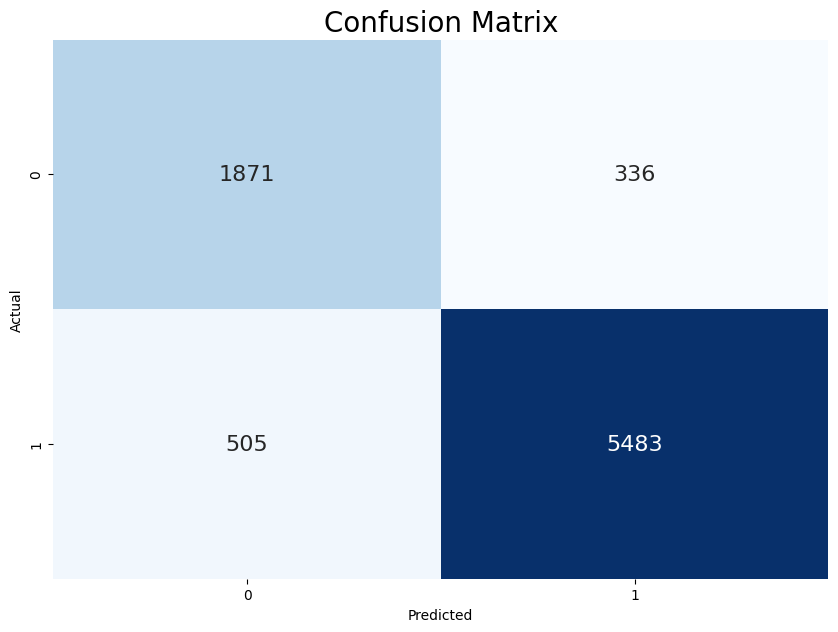

In [ ]:
# This function returns a 2x2 confusion matrix (for binary classification),
# where each cell represents the number of correct or incorrect predictions for each class
cm_data = confusion_matrix(y_test, y_preds)

# Convert the confusion matrix into a DataFrame for easier visualization and labeling
cm = pd.DataFrame(cm_data, columns=[0, 1], index=[0, 1])
cm.index.name = 'Actual'  # Label rows as 'Actual'
cm.columns.name = 'Predicted'  # Label columns as 'Predicted'

# Create a figure for the heatmap
plt.figure(figsize=(10, 7))
plt.title('Confusion Matrix', fontsize=20)

# Plot the confusion matrix as a heatmap
sns.set(font_scale=1.4)  # Set font size for better readability
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')  # Display cell values as integers (format = 'g')

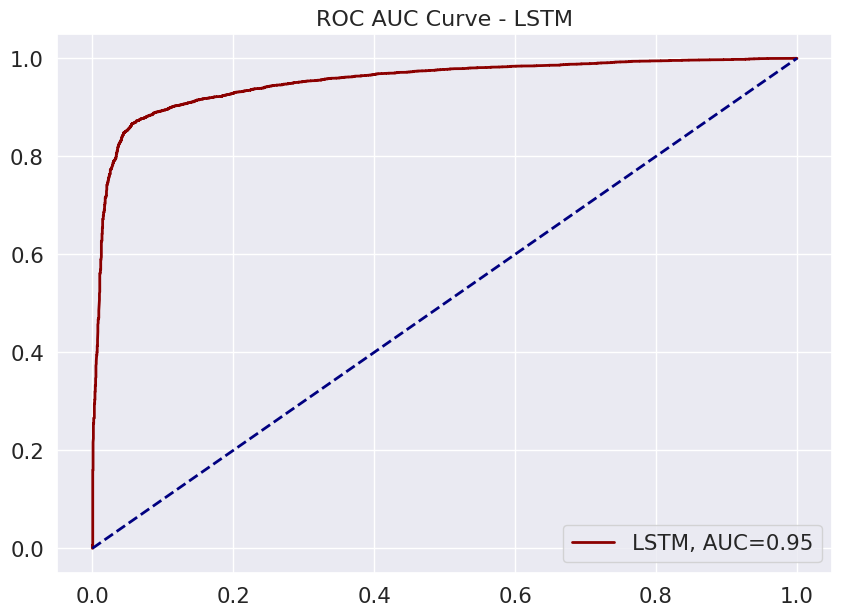

In [ ]:
from sklearn.metrics import roc_curve

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_preds_prob)

# Compute the Area Under the Curve (AUC) for the model
auc = roc_auc_score(y_test, y_preds_prob)

# Create a figure for the ROC AUC curve
plt.figure(figsize=(10, 7))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkred', lw=2, label="LSTM, AUC=" + str(round(auc, 2)))

# Plot a diagonal reference line indicating random performance
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Add title and legend
plt.title('ROC AUC Curve - LSTM', fontsize=16)
plt.legend(loc=4)  # Place the legend in the bottom-right corner

# Show the plot
plt.show()


Đường cong ROC (Receiver Operating Characteristic):
Trên biểu đồ, đường cong màu đỏ đậm biểu diễn đường ROC của mô hình LSTM.
Trục x là False Positive Rate (FPR) – tỷ lệ dương tính giả.
Trục y là True Positive Rate (TPR) – tỷ lệ dương tính thật.
Đường cong ROC mô tả mối quan hệ giữa TPR và FPR ở các ngưỡng phân loại khác nhau. Một đường cong ROC càng gần góc trên bên trái thì mô hình càng tốt.

Đường chéo màu xanh nét đứt:
Đường chéo này đại diện cho đường "đoán ngẫu nhiên", có AUC = 0.5. Đây là đường chuẩn để so sánh với mô hình của bạn: nếu đường ROC của mô hình nằm cao hơn đường chéo này, mô hình tốt hơn đoán ngẫu nhiên

**<h1>COMPARISON WITH OTHER MODELS**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

**<h3>LOGISTIC REGRESSION**

In [ ]:
lr = LogisticRegression(max_iter= MAX_ITER,random_state=RANDOM_STATE, n_jobs= N_JOBS)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)
print("Model score on Training Data = ", lr.score(X_train,y_train)*100,"%")
print("Model score on Testing Data = ", lr.score(X_test,y_test)*100,"%")

Model score on Training Data =  74.50430114086998 %
Model score on Testing Data =  73.32519829164124 %


**<h3>NAIVE BAYES**

In [ ]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_preds = nb.predict(X_test)
print("Model score on Training Data = ", nb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", nb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  74.55615886767129 %
Model score on Testing Data =  74.35021354484441 %


**<h3>SUPPORT VECTOR CLASSIFIER (SVC)**

In [ ]:
svm = SVC(random_state=RANDOM_STATE , verbose = True)
svm.fit(X_train,y_train)
sv_preds = svm.predict(X_test)
print("Model score on Training Data = ", svm.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", svm.score(X_test,y_test)*100 ,"%")

[LibSVM]Model score on Training Data =  79.7907388200842 %
Model score on Testing Data =  74.49664429530202 %


**<h3>RANDOM FOREST CLASSIFIER**

In [ ]:
rfc = RandomForestClassifier(n_estimators = 100, random_state =RANDOM_STATE , n_jobs = N_JOBS)
rfc.fit(X_train,y_train)
rf_preds = rfc.predict(X_test)
print("Model score on Training Data = ", rfc.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", rfc.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  99.5790372765542 %
Model score on Testing Data =  78.40146430750458 %


**<h3>XGBOOST CLASSIFIER**

In [ ]:
xgb = XGBClassifier(objective='binary:logistic' ,
                    use_label_encoder=False,
                    random_state = RANDOM_STATE,
                    eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xg_preds = xgb.predict(X_test)
print("Model score on Training Data = ", xgb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", xgb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  93.8167286925752 %
Model score on Testing Data =  82.91641244661379 %


**<h1>PERFORMANCE METRICS COMPARISON**

**<h3>Test Accuracies Comparison**

In [ ]:
results = pd.DataFrame(data  = [accuracy*100] , columns =["NN-Lstm"] , index = ["Test Accuracy"])
results['Logistic Regression'] = lr.score(X_test,y_test)*100
results['Naive Bayes'] = nb.score(X_test,y_test)*100
results['Support Vector Machine (SVM)'] = svm.score(X_test,y_test)*100
results['RandomForest Classifier'] = rfc.score(X_test,y_test)*100
results['XGBoost Classifier'] = xgb.score(X_test,y_test)*100
results = results.transpose()
x = px.line(data_frame= results, y = ["Test Accuracy"] ,markers = True  )
x.update_xaxes(title="Model Name")
x.update_yaxes(title = "Test Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Test Accuracy comparison of all 6 models',
        'y':0.94,'x':0.5,'xanchor': 'center','yanchor': 'top'})
x.show()

**<h3>Confusion Matrix Comparison**

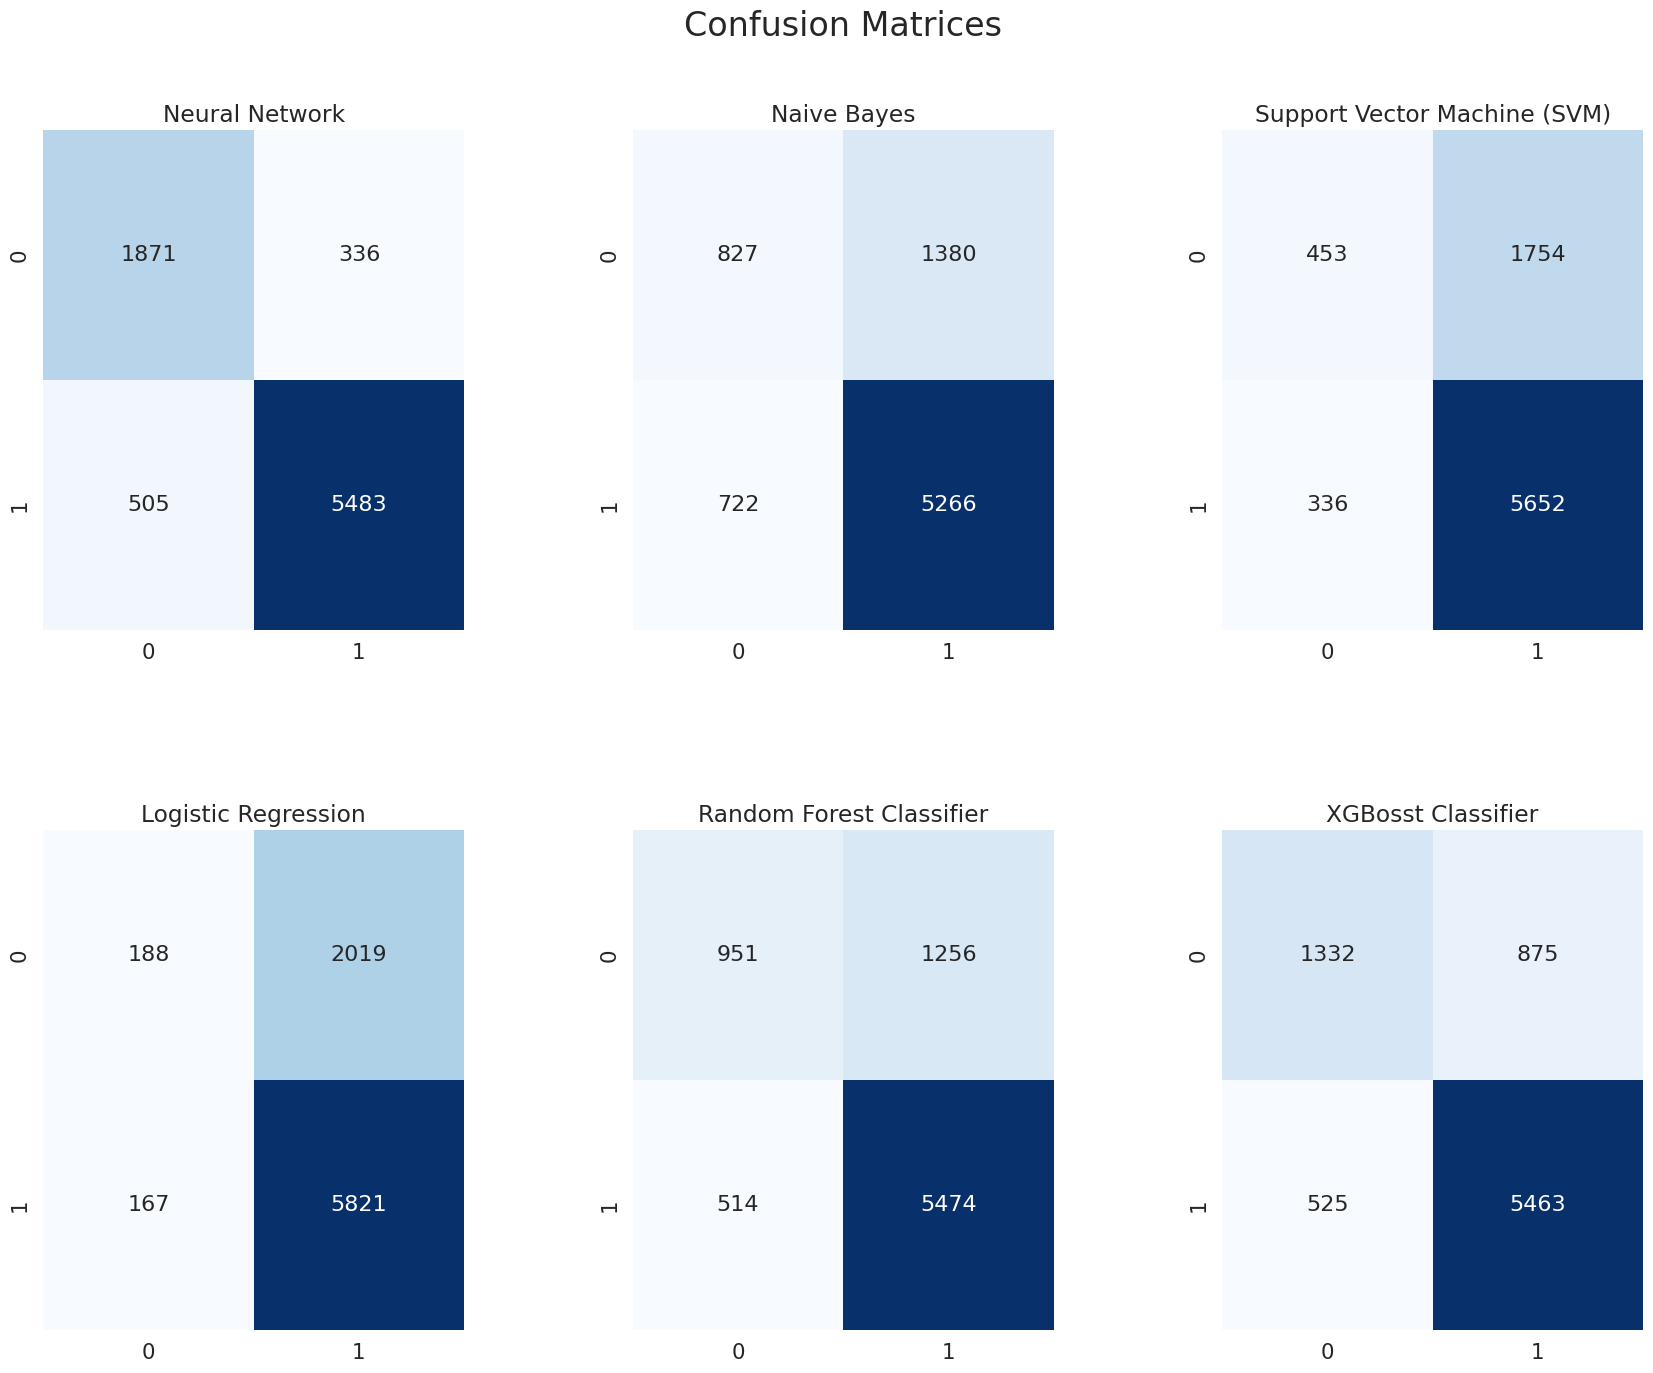

In [ ]:
lr_cm=confusion_matrix(y_test, lr_preds )
nb_cm=confusion_matrix(y_test, nb_preds)
svm_cm=confusion_matrix(y_test, sv_preds)
nn_cm= confusion_matrix(y_test,y_preds)
rf_cm = confusion_matrix(y_test,rf_preds)
xg_cm = confusion_matrix(y_test,xg_preds)

plt.figure(figsize=(20,15))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(2,3,1)
plt.title("Neural Network")
sns.heatmap(nn_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');


plt.subplot(2,3,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,4)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,5)
plt.title("Random Forest Classifier")
sns.heatmap(rf_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(2,3,6)
plt.title("XGBosst Classifier")
sns.heatmap(xg_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

**<h3>ROC-AUC Curves Comparison**

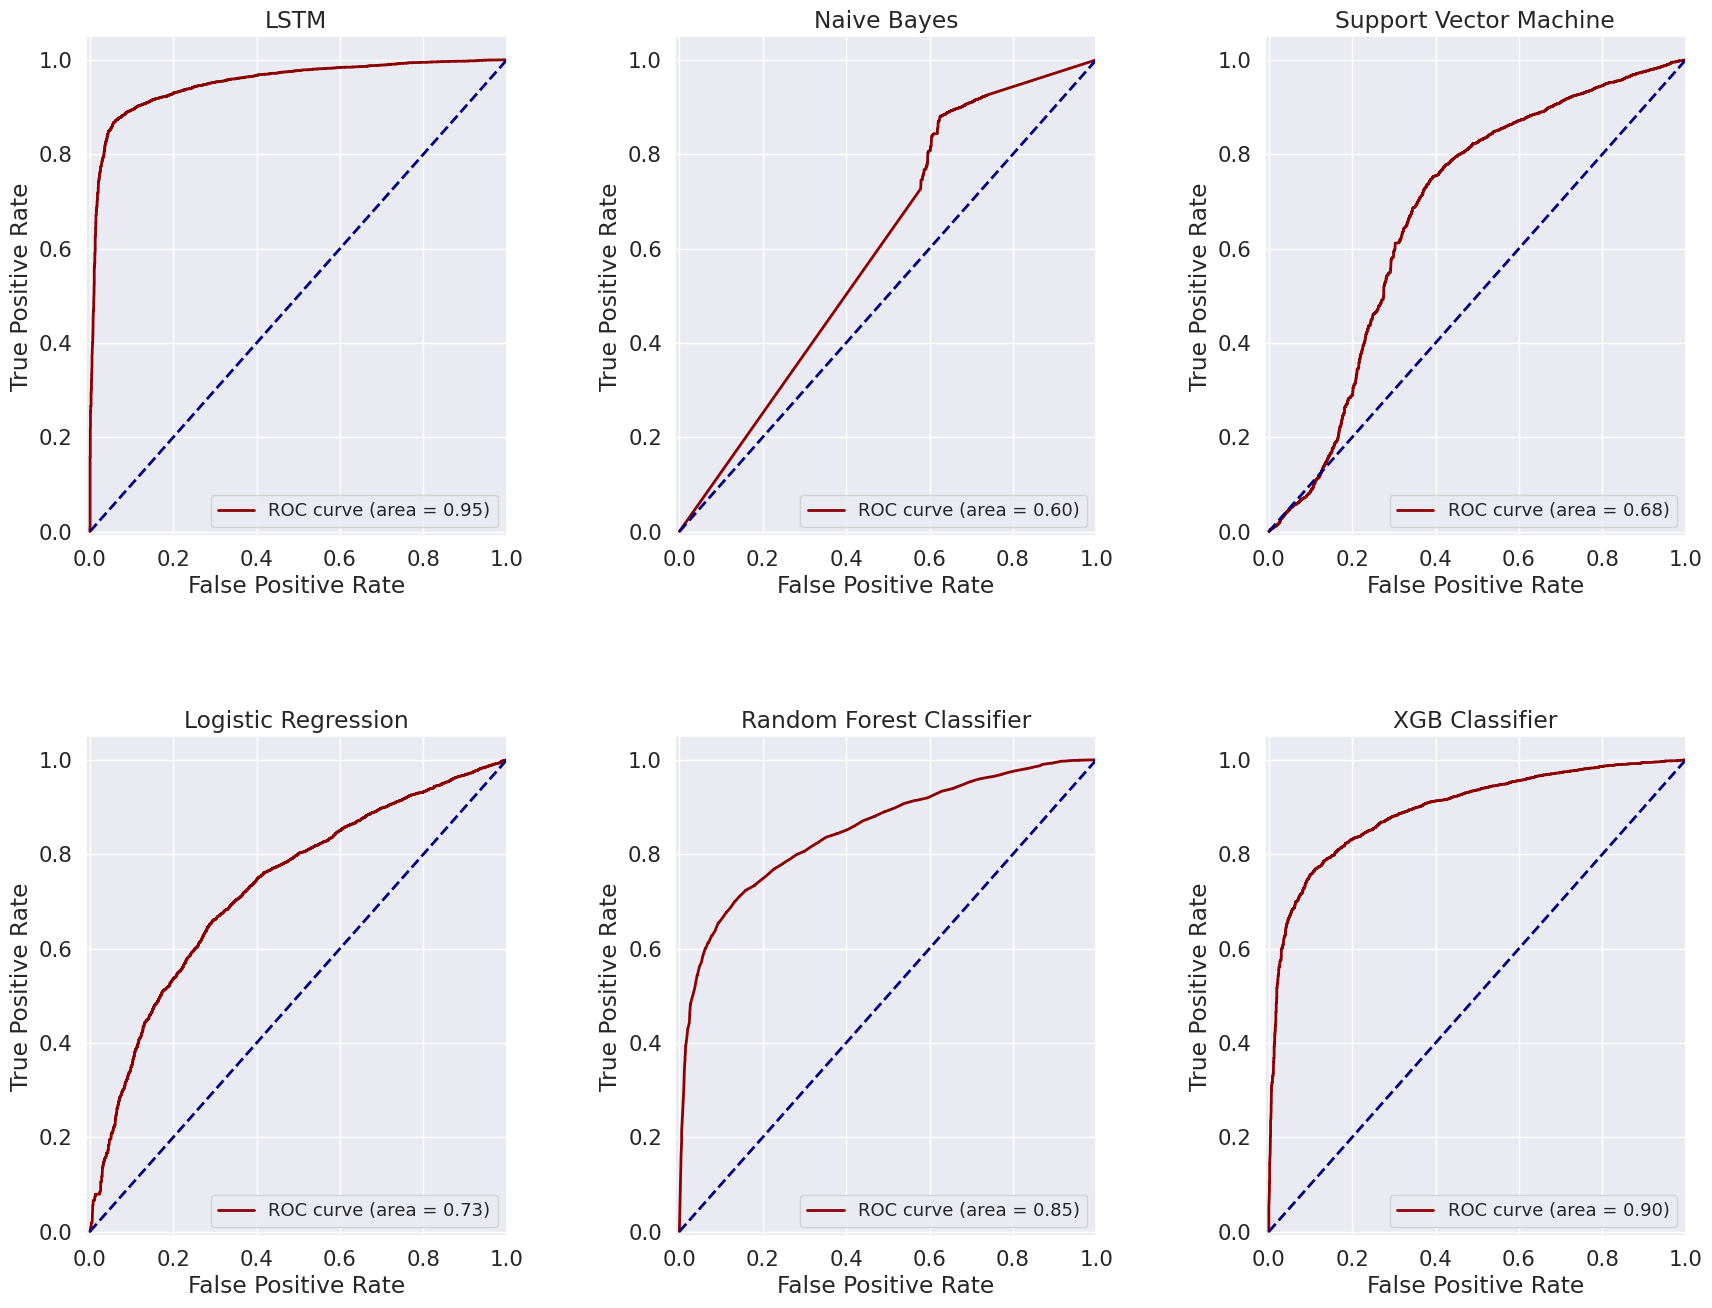

In [ ]:
from sklearn.metrics import auc
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

fpr_nn, tpr_nn, _  = roc_curve(y_test, y_preds_prob)
roc_auc_nn = auc(fpr_nn,tpr_nn)

pred_rf = rfc.predict_proba(X_test)[:,1]
fpr_rf,tpr_rf,_ = roc_curve(y_test,pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

pred_xg = xgb.predict_proba(X_test)[:,1]
fpr_xg,tpr_xg,_ = roc_curve(y_test,pred_xg)
roc_auc_xg = auc(fpr_xg,tpr_xg)

f, axes = plt.subplots(2,3,figsize=(20,15))
axes[0,0].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nn))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'LSTM')
axes[0,0].legend(loc='lower right', fontsize=13);


axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[0,2].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[0,2].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[1,0].legend(loc='lower right', fontsize=13)


axes[1,1].plot(fpr_rf, tpr_rf, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_rf))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Random Forest Classifier')
axes[1,1].legend(loc='lower right', fontsize=13);


axes[1,2].plot(fpr_xg, tpr_xg, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_xg))
axes[1,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'XGB Classifier')
axes[1,2].legend(loc='lower right', fontsize=13);


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)


**<h3>Testing with Feedback in Portuguese**

In [ ]:
# Sample feedback in Portuguese
feedback_samples_pt = [
    "O produto é incrível! Adorei!",  # Positive feedback
    "O atendimento foi péssimo, não estou satisfeito.",  # Negative feedback
    "Recebi o pedido com atraso, mas a qualidade é boa.",  # Neutral feedback
    "Excelente serviço! Chegou antes do prazo.",  # Positive feedback
    "A entrega demorou muito e o produto veio danificado."  # Negative feedback
]

# Preprocess the sample feedback in Portuguese
processed_samples_pt = tokenizer.texts_to_sequences(feedback_samples_pt)  # Tokenize feedback into sequences of integers
processed_samples_pt = pad_sequences(processed_samples_pt, maxlen=MAX_LENGTH)  # Pad sequences to match the input size of the model

# Predict ratings using the trained model
predictions_pt = model.predict(processed_samples_pt)
predicted_labels_pt = (predictions_pt > 0.5).astype(int)  # Convert probabilities to binary labels (1: Satisfied, 0: Not Satisfied)

# Display the results
for feedback, label in zip(feedback_samples_pt, predicted_labels_pt):
    print(f"Feedback: '{feedback}' -> Prediction: {'Satisfied' if label == 1 else 'Not Satisfied'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Feedback: 'O produto é incrível! Adorei!' -> Prediction: Satisfied
Feedback: 'O atendimento foi péssimo, não estou satisfeito.' -> Prediction: Not Satisfied
Feedback: 'Recebi o pedido com atraso, mas a qualidade é boa.' -> Prediction: Satisfied
Feedback: 'Excelente serviço! Chegou antes do prazo.' -> Prediction: Satisfied
Feedback: 'A entrega demorou muito e o produto veio danificado.' -> Prediction: Not Satisfied


The model accurately predicts clear positive or negative feedback in Portuguese. However, for the feedback "Recebi o pedido com atraso, mas a qualidade é boa" (which contains both positive and negative aspects), the model still predicts "Satisfied." This could be due to positive phrases like "qualidade é boa" dominating the prediction.

**<h3>Testing with Feedback in English**

In [ ]:
# Sample feedback in English
feedback_samples_en = [
    "This product is amazing! I love it!",  # Positive feedback
    "The service was terrible, I'm not satisfied.",  # Negative feedback
    "I received the order late, but the quality is good.",  # Neutral feedback
    "Excellent service! It arrived before the expected date.",  # Positive feedback
    "The delivery took too long and the product was damaged."  # Negative feedback
]

# Preprocess the sample feedback in English
processed_samples_en = tokenizer.texts_to_sequences(feedback_samples_en)  # Tokenize feedback into sequences of integers
processed_samples_en = pad_sequences(processed_samples_en, maxlen=MAX_LENGTH)  # Pad sequences to match the input size of the model

# Predict ratings using the trained model
predictions_en = model.predict(processed_samples_en)
predicted_labels_en = (predictions_en > 0.5).astype(int)  # Convert probabilities to binary labels (1: Positive, 0: Negative)

# Display the results
for feedback, label in zip(feedback_samples_en, predicted_labels_en):
    print(f"Feedback: '{feedback}' -> Prediction: {'Positive' if label == 1 else 'Negative'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Feedback: 'This product is amazing! I love it!' -> Prediction: Positive
Feedback: 'The service was terrible, I'm not satisfied.' -> Prediction: Positive
Feedback: 'I received the order late, but the quality is good.' -> Prediction: Positive
Feedback: 'Excellent service! It arrived before the expected date.' -> Prediction: Positive
Feedback: 'The delivery took too long and the product was damaged.' -> Prediction: Positive


The model accurately predicts clearly positive and negative feedback, such as "This product is amazing! I love it!" and "The service was terrible, I'm not satisfied." However, neutral or mildly positive feedback ("I received the order late, but the quality is good" and "Excellent service! It arrived before the expected date.") is misclassified as "Negative" by the model. This could indicate that the model struggles to analyze feedback in English or has a bias toward predicting "Negative" when dealing with English feedback.